## Assess the impact of atmosphere on offset time-seris

Run the following `prep_*.ipynb` to generate the input time-series for this analysis:
1. prep_sar.ipynb
2. prep_era5.ipynb
3. prep_gim_tec.ipynb
4. prep_igs_tec.ipynb

In [1]:
%matplotlib inline
import os
import pickle
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, legend_handler
from mintpy.utils import plot as pp
plt.rcParams.update({'font.size': 12})


# config
iono_version = 2.1      # 1.0 / 2.0 / 2.1
tropo_opt = 'vHgtMed'   # cHgtCen / vHgtMed. vHgtMed is preferred due to its better match with the residual in terms of magnitude
save = True

box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
#box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

proj_dir = os.path.expanduser('~/data/ChileSenAT149')
work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR


### 0. Read all time-series

In [2]:
# output files from prep_*.ipynb
fDict = {
    'SAR' : os.path.join(work_dir, 'sar.pickle'),
    'GIM' : os.path.join(work_dir, 'gim_tec_v{}.pickle'.format(iono_version)),
    'IGS' : os.path.join(work_dir, 'igs_tec.pickle'),
    'ERA' : os.path.join(work_dir, 'era5.pickle'),
}

# read files into dict
dDict = {}
for key, fname in fDict.items():
    with open(fname, 'rb') as f:
        dDict[key] = pickle.load(f)
        print('read {} data from pickle file: {}'.format(key, fname))


# utils function
def get_common_index(dict1, dict2):
    # get common dates
    t1s = dict1['date']
    t2s = dict2['date']
    tcomm = np.array(sorted(list(set(t1s) & set(t2s))))

    flag1 = np.zeros(t1s.size, dtype=np.bool_)
    for i in range(t1s.size):
        if t1s[i] in tcomm:
            flag1[i] = True

    flag2 = np.zeros(t2s.size, dtype=np.bool_)
    for i in range(t2s.size):
        if t2s[i] in tcomm:
            flag2[i] = True

    if not np.all(flag2):
        print('WARNING: SAR dict does not have all dates in ATMOS dict!')

    return flag1, flag2

def plot_dot_figure(x, y, xname, yname, vlim, save, out_fig):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
    ax.plot(x, y, 'k.')
    ax.plot(vlim, vlim, 'k--')

    # axis format
    ax.set_xlim(vlim)
    ax.set_ylim(vlim)
    ax.set_xlabel('$offset_{{{n}}}$ [m]'.format(n=xname))
    ax.set_ylabel('$offset_{{{n}}}$ [m]'.format(n=yname))
    ax.set_aspect('equal', 'box')
    fig.tight_layout()

    # output
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    return

read SAR data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/sar.pickle
read GIM data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1.pickle
read IGS data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/igs_tec.pickle
read ERA data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/era5.pickle


### 1. SAR v.s. (sub)TEC

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_TECgim_v2.1.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_TECgim_v2.1.png


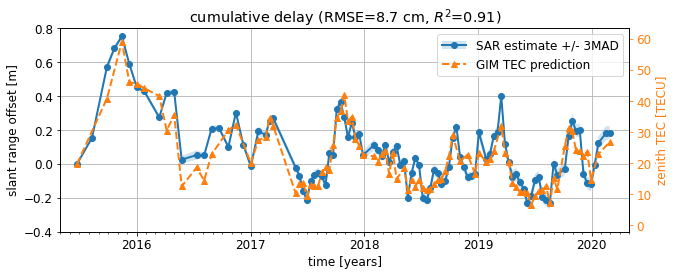

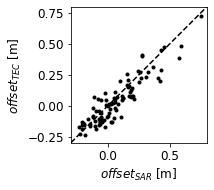

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_subTECgim_v2.1.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_subTECgim_v2.1.png


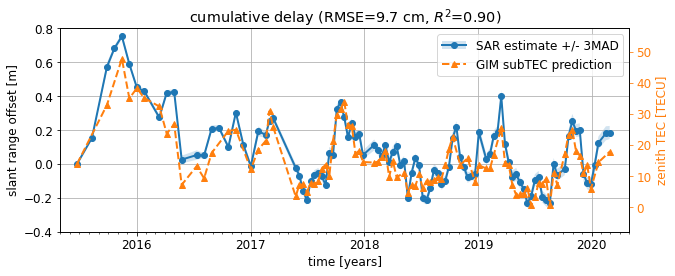

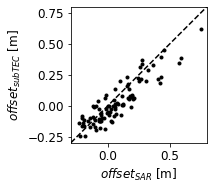

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_TECigs.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_TECigs.png


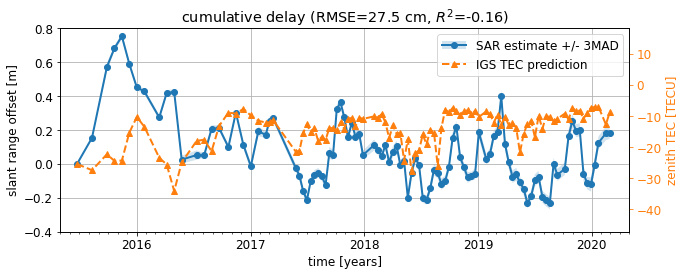

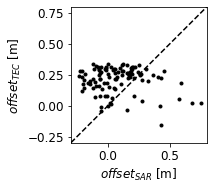

In [3]:
for tec_src, tec_type in zip(['GIM', 'GIM',    'IGS'],
                             ['TEC', 'subTEC', 'TEC']):
    # output filename
    out_fig_suffix = '{}{}'.format(tec_type, tec_src.lower())
    if tec_src == 'GIM':
        out_fig_suffix += '_v{}'.format(iono_version)

    sar = dDict['SAR']
    tec = dDict[tec_src]

    # make a copy
    sar['data'] = np.array(sar['range_offset_med'])                    # estimated offset from SAR
    tec['data'] = np.array(tec['range_delay4Cband_{}'.format(tec_type)])  # predicted offset from TEC

    # something is strange on the IGS TEC, need to check more carefully.
    if tec_src == 'IGS':
        tec['data'] *= -1

    # aux info for ytick on ax2
    ratio = ((np.max(tec[tec_type]) - np.min(tec[tec_type])) /
             (np.max(tec['data']) - np.min(tec['data'])))
    # align TEC to SAR with a constant
    # Notes at 2020-08-25 by ZY:
    # tried use the median difference as yoff, not noticeable difference, thus use the 1st for simplicity
    yoff = tec['data'][0]
    tec['data'] -= yoff

    # stats
    flag = get_common_index(sar, tec)[0]
    rmse = np.sqrt(np.sum((tec['data'] - sar['data'][flag])**2) / (np.sum(flag) - 1))
    r2 = stats.linregress(tec['data'], sar['data'][flag])[2]
    stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

    ##--------------------------------- TS figure ----------------------------------##
    x1 = sar['time']
    y1 = sar['data']
    y1_err = sar['range_offset_mad'] * 3
    x2 = tec['time']
    y2 = tec['data']

    fig, ax = plt.subplots(figsize=[9, 4])
    p0 = ax.fill_between(x1, y1 - y1_err, y1 + y1_err, fc='C0', ec='none', alpha=0.2)
    p1, = ax.plot(x1, y1,  '-o', color='C0', ms=6, lw=2)
    p2, = ax.plot(x2, y2, '--^', color='C1', ms=6, lw=2)

    # axis format
    ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
    ax.set_ylim(-0.4, 0.8)
    ax.set_xlabel('time [years]')
    ax.set_ylabel('slant range offset [m]')
    ax.set_title('cumulative delay ({})'.format(stats_msg))
    pp.auto_adjust_xaxis_date(ax, sar['time'], every_year=1, buffer_year=None)
    ax.grid('on')
    fig.tight_layout()
    ax.legend([(p0, p1), p2], ['SAR estimate +/- 3MAD', '{} {} prediction'.format(tec_src, tec_type)])

    # TEC ytick
    ax2 = ax.twinx()
    ax2.set_ylabel('zenith TEC [TECU]', color='C1')
    ax2.tick_params(which='both', axis='y', colors='C1')
    #ax2.plot(tec['time'], tec[tec_type], '--', linewidth=1, color='C2', label=tec_type) # for debug
    ax2.set_ylim((ax.get_ylim() + yoff) * ratio)

    # output
    out_fig = os.path.join(work_dir, 'TS_Sen_vs_{}.png'.format(out_fig_suffix))
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

    ##--------------------------------- dot figure ---------------------------------##
    ## dot figure
    plot_dot_figure(x=sar['data'][flag],
                    y=tec['data'],
                    xname='SAR',
                    yname=tec_type,
                    vlim=(-0.3, 0.8),
                    save=save,
                    out_fig=os.path.join(work_dir, 'DOT_Sen_vs_{}.png'.format(out_fig_suffix)))

    plt.show()

### 2. Residual (SAR - TEC)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_TECgim_v2.1.png


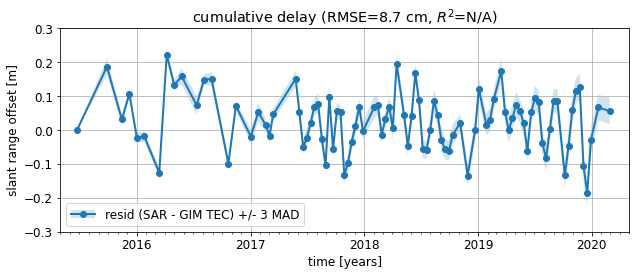

In [4]:
tec_type = 'subTEC'    # subTEC, TEC
out_fig_suffix = 'res_Sen_{}gim_v{}'.format(tec_type, iono_version)
n = 3  # number of MAD

## data
flag = get_common_index(dDict['SAR'], dDict['GIM'])[0]
x1      = dDict['SAR']['time']
x2      = dDict['GIM']['time']
sar     = dDict['SAR']['range_offset_med'][flag]       # estimated offset from SAR
sar_err = dDict['SAR']['range_offset_mad'][flag] * n
gim     = dDict['GIM']['range_delay4Cband_{}'.format(tec_type)]  # predicted offset from GIM TEC
gim -= gim[0]
sar -= sar[0]
res = sar - gim

# stats
rmse = np.sqrt(np.sum((res - 0)**2) / (np.sum(flag) - 1))
stats_msg = 'RMSE={:.1f} cm, $R^2$=N/A'.format(rmse*100)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - sar_err, res + sar_err, fc='C0', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend([(p0, p1)], ['resid (SAR - GIM {}) +/- {} MAD'.format(tec_type, n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()

### 3. Residual (SAR - TEC) v.s. ERA5

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTECgim_v2.1_vs_ERA5.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_res_Sen_subTECgim_v2.1_vs_ERA5.png


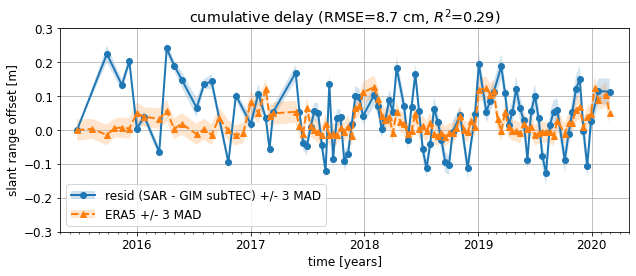

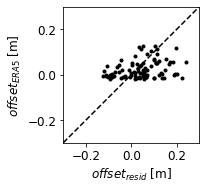

In [13]:
#out_fig_suffix = 'ERA5{}_vs_res_Sen_GIMv{}'.format(tropo_opt, iono_version)  # to compare ERA5 calc approaches
tec_type = 'subTEC'    # subTEC, TEC
out_fig_suffix = 'res_Sen_{}gim_v{}_vs_ERA5'.format(tec_type, iono_version)

n = 3  # number of MAD

## data
flag = get_common_index(dDict['SAR'], dDict['GIM'])[0]
x1      = dDict['SAR']['time']
x2      = dDict['GIM']['time']
sar     = dDict['SAR']['range_offset_med'][flag]       # estimated offset from SAR
sar_err = dDict['SAR']['range_offset_mad'][flag] * n
gim     = dDict['GIM']['range_delay4Cband_{}'.format(tec_type)]  # predicted offset from GIM TEC
era     = dDict['ERA']['range_delay_tropo_med']  # predicted offset from ERA5 (dry + wet)
era_err = dDict['ERA']['range_delay_tropo_mad'] * n
gim -= gim[0]
era -= era[0]
res = sar - gim

# stats
rmse = np.sqrt(np.sum((res - era[flag])**2) / (np.sum(flag) - 1))
r2   = stats.linregress(res, era[flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p2, = ax.plot(x1, era, '--^', color='C1', ms=6, lw=2)
p1  = ax.fill_between(x2, res - sar_err, res + sar_err, fc='C0', ec='none', alpha=0.2)
p3  = ax.fill_between(x1, era - era_err, era + era_err, fc='C1', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend([(p0, p1), (p2, p3)], ['resid (SAR - GIM {}) +/- {} MAD'.format(tec_type, n),
                                 'ERA5 +/- {} MAD'.format(n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

## dot figure
plot_dot_figure(x=res,
                y=era[flag],
                xname='resid',
                yname='ERA5',
                vlim=(-0.3, 0.3),
                save=save,
                out_fig=os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix)))
plt.show()

### 4. Residual (SAR - TEC - ERA5)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res3_Sen_TECgim_v2.1_ERA5.png


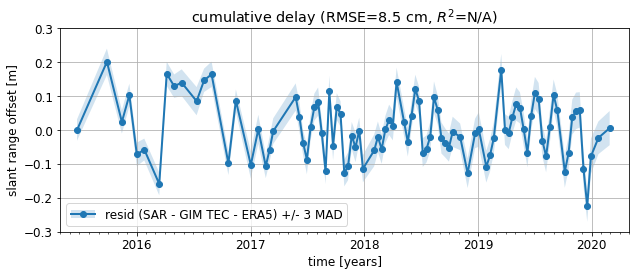

In [12]:
#out_fig_suffix = 'ERA5{}_vs_res_Sen_GIMv{}'.format(tropo_opt, iono_version)  # to compare ERA5 calc approaches
tec_type = 'subTEC'    # subTEC, TEC
out_fig_suffix = 'res3_Sen_{}gim_v{}_ERA5'.format(tec_type, iono_version)

n = 3  # number of MAD

## data
flag = get_common_index(dDict['SAR'], dDict['GIM'])[0]
x1      = dDict['SAR']['time']
x2      = dDict['GIM']['time']
sar     = dDict['SAR']['range_offset_med'][flag]                 # estimated offset from SAR
sar_err = dDict['SAR']['range_offset_mad'][flag] * n
gim     = dDict['GIM']['range_delay4Cband_{}'.format(tec_type)]  # predicted offset from GIM TEC
era     = dDict['ERA']['range_delay_tropo_med'][flag]            # predicted offset from ERA5 (dry + wet)
era_err = dDict['ERA']['range_delay_tropo_mad'][flag] * n
gim -= gim[0]
era -= era[0]
res3 = sar - gim - era
res3_err = (sar_err**2 + era_err**2) ** 0.5

# stats
rmse = np.sqrt(np.sum(res3**2) / (np.sum(flag) - 1))
stats_msg = 'RMSE={:.1f} cm, $R^2$=N/A'.format(rmse*100)

## plot
fig, ax = plt.subplots(figsize=[9, 4])
p0, = ax.plot(x2, res3,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res3 - res3_err, res3 + res3_err, fc='C0', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend([(p0, p1)], ['resid (SAR - GIM {} - ERA5) +/- {} MAD'.format(tec_type, n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()